In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpu)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
REAL_AUDIO_PATH = "C:\\Users\\Tarun\\Documents\\Project SP\\Fake-Or-Real (FoR)\\for-2seconds\\training\\real"
FAKE_AUDIO_PATH = "C:\\Users\\Tarun\\Documents\\Project SP\\Fake-Or-Real (FoR)\\for-2seconds\\training\\fake"
NUM_CLASSES = 2  
SAMPLE_RATE = 16000
DURATION = 2 
N_MELS = 128  
MAX_TIME_STEPS = 87 

In [3]:
def preprocess_audio_files(audio_path, label):
    X = []
    y = []
    for file_name in os.listdir(audio_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_path, file_name)
            audio, i = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
            else:
                mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]
                
            X.append(mel_spectrogram)
            y.append(label)
    
    return np.array(X), np.array(y)

In [4]:
def show_mel_spectrograms(X, y, num_samples=5):
    plt.figure(figsize=(20, 4 * num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        librosa.display.specshow(X[i], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', cmap='plasma')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Label: {y[i]}')
        plt.xlim(0, 2) 
    plt.tight_layout()
    plt.show()

In [5]:
X_real, y_real = preprocess_audio_files(REAL_AUDIO_PATH, 1)
X_fake, y_fake = preprocess_audio_files(FAKE_AUDIO_PATH, 0)

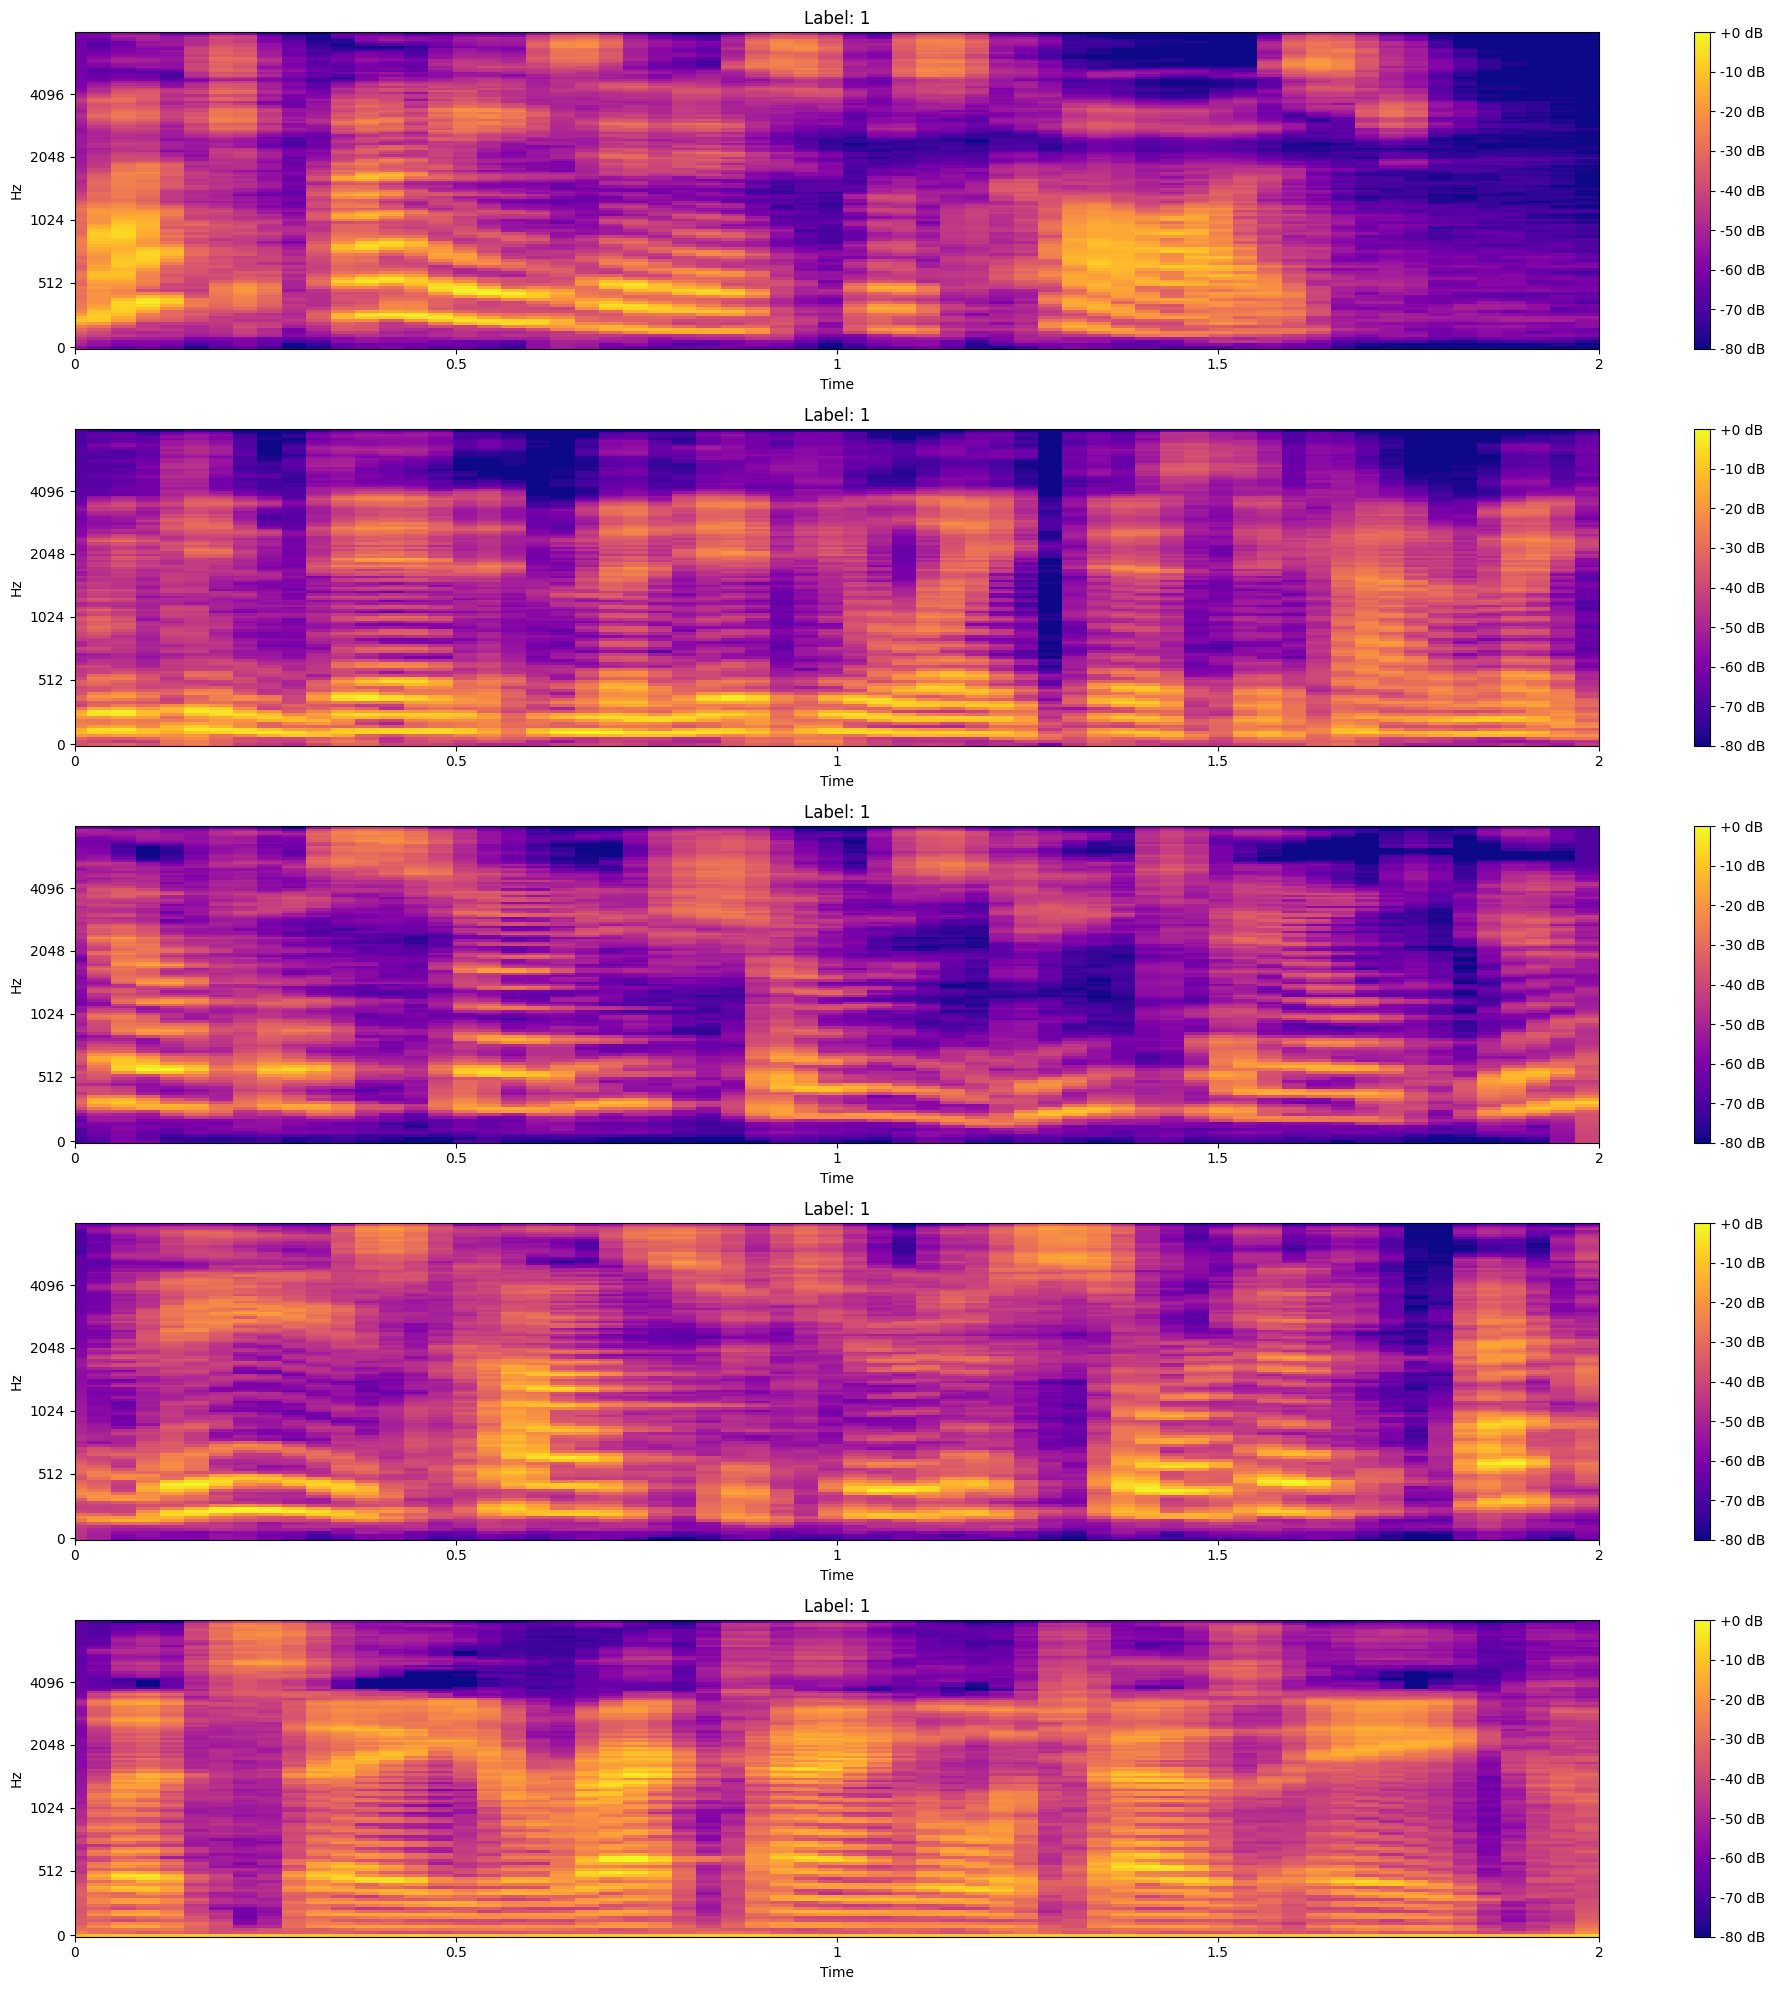

In [6]:
show_mel_spectrograms(X_real, y_real, num_samples=5)

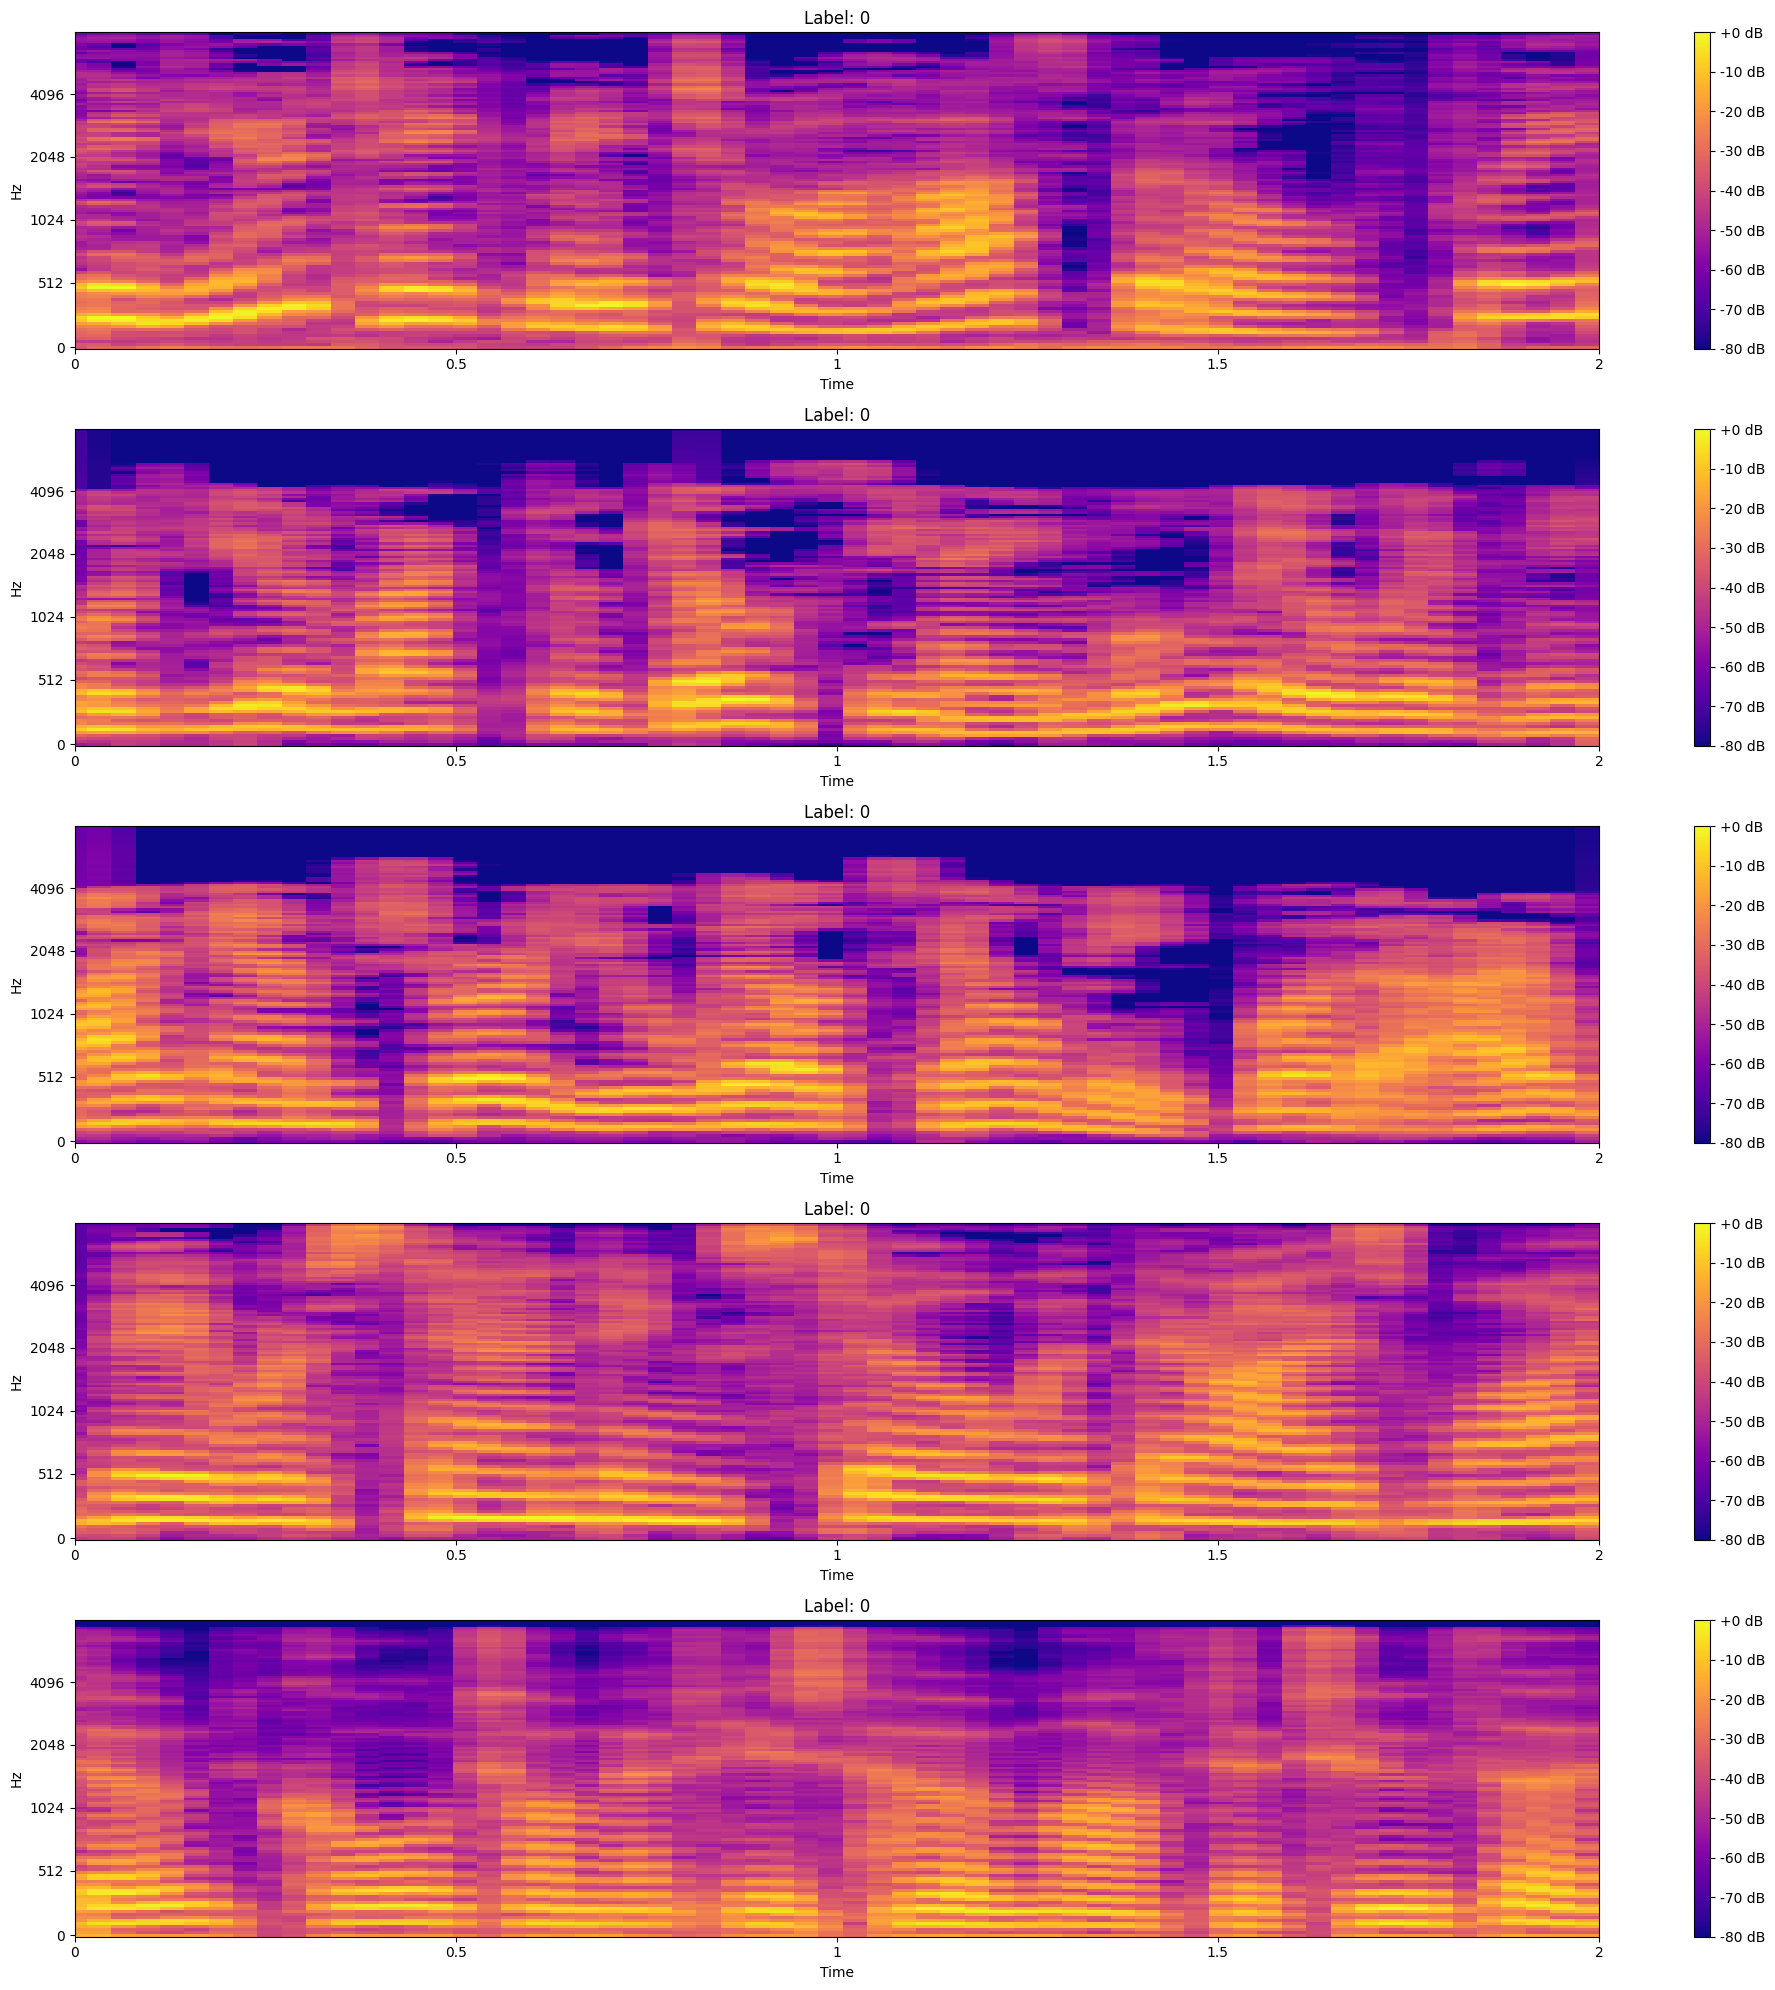

In [7]:
show_mel_spectrograms(X_fake, y_fake, num_samples=5)

In [8]:
X = np.concatenate((X_real, X_fake), axis=0)
y = np.concatenate((y_real, y_fake), axis=0)

In [9]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [10]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y_encoded = y_encoded[indices]

In [11]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (11164, 128, 87)
y_train shape: (11164, 2)
X_val shape: (2792, 128, 87)
y_val shape: (2792, 2)


In [13]:
X_train[0].shape

(128, 87)

In [14]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import joblib

In [15]:
len(X_train)

11164

In [16]:
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [17]:
model = Model(inputs=model_input, outputs=model_output)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
349/349 [==============================] - 23s 31ms/step - loss: 2.0139 - accuracy: 0.7421 - val_loss: 0.4499 - val_accuracy: 0.7962
Epoch 2/10
349/349 [==============================] - 10s 28ms/step - loss: 0.2671 - accuracy: 0.8826 - val_loss: 0.1705 - val_accuracy: 0.9266
Epoch 3/10
349/349 [==============================] - 10s 28ms/step - loss: 0.1798 - accuracy: 0.9265 - val_loss: 0.1233 - val_accuracy: 0.9516
Epoch 4/10
349/349 [==============================] - 10s 28ms/step - loss: 0.1378 - accuracy: 0.9470 - val_loss: 0.0986 - val_accuracy: 0.9642
Epoch 5/10
349/349 [==============================] - 10s 28ms/step - loss: 0.0884 - accuracy: 0.9682 - val_loss: 0.1097 - val_accuracy: 0.9581
Epoch 6/10
349/349 [==============================] - 10s 28ms/step - loss: 0.0568 - accuracy: 0.9793 - val_loss: 0.0839 - val_accuracy: 0.9731
Epoch 7/10
349/349 [==============================] - 10s 28ms/step - loss: 0.0479 - accuracy: 0.9820 - val_loss: 0.0787 - val_accuracy:

In [38]:
# model.save("my-model.h5")

In [21]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [22]:
TEST_DATASET_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\fake"
MODEL_PATH = r"C:\Users\Tarun\Mini\my-model.h5"
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 87

In [23]:
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

X_test = np.array(X_test)

y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

45/45 [==============================] - 1s 15ms/step


array([[9.4786048e-01, 5.2139498e-02],
       [7.2304279e-01, 2.7695721e-01],
       [1.0000000e+00, 2.8436140e-20],
       ...,
       [1.0000000e+00, 5.7920183e-12],
       [9.9999714e-01, 2.8928698e-06],
       [1.0000000e+00, 2.5003365e-12]], dtype=float32)

In [24]:
print("Predicted classes:", y_pred_classes)

Predicted classes: [0 0 0 ... 0 0 0]


In [25]:
TEST_DATASET_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\real"

In [26]:
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

X_test = np.array(X_test)

y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

45/45 [==============================] - 1s 12ms/step


array([[1.8067716e-05, 9.9998188e-01],
       [9.3561393e-05, 9.9990642e-01],
       [1.2568265e-03, 9.9874324e-01],
       ...,
       [5.8132326e-09, 1.0000000e+00],
       [4.3687741e-03, 9.9563122e-01],
       [6.6656437e-05, 9.9993336e-01]], dtype=float32)

In [27]:
print("Predicted classes:", y_pred_classes)

Predicted classes: [1 1 1 ... 1 1 1]


In [28]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Define paths
FAKE_AUDIO_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\fake"
REAL_AUDIO_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\real"
MODEL_PATH = r"C:\Users\Tarun\Mini\my-model.h5"

# Define constants
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 87

# Function to preprocess audio files
def preprocess_audio_files(audio_path):
    X = []
    for file_name in os.listdir(audio_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_path, file_name)
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
            else:
                mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]
            X.append(mel_spectrogram)
    return np.array(X)

X_fake = preprocess_audio_files(FAKE_AUDIO_PATH)
X_real = preprocess_audio_files(REAL_AUDIO_PATH)

X_test = np.concatenate((X_fake, X_real), axis=0)

X_test = X_test[..., np.newaxis]

model = load_model(MODEL_PATH)

y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

print("Predicted classes:", y_pred_classes)

89/89 [==============================] - 1s 13ms/step
Predicted classes: [0 0 0 ... 1 1 1]


In [29]:
len(y_pred_classes)

2826

In [30]:
# Define the paths to the directories containing fake and real audio files
FAKE_AUDIO_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\fake"
REAL_AUDIO_PATH = r"C:\Users\Tarun\Documents\Project SP\Fake-Or-Real (FoR)\for-2seconds\validation\real"

# Get a list of all file names in the fake audio directory
fake_file_names = [file_name for file_name in os.listdir(FAKE_AUDIO_PATH) if file_name.endswith('.wav')]

# Create a dictionary with file names labeled as 0 (fake)
file_labels_fake = {file_name: 0 for file_name in fake_file_names}

# Get a list of all file names in the real audio directory
real_file_names = [file_name for file_name in os.listdir(REAL_AUDIO_PATH) if file_name.endswith('.wav')]

# Create a dictionary with file names labeled as 1 (real)
file_labels_real = {file_name: 1 for file_name in real_file_names}

# Merge the two dictionaries
file_labels = {**file_labels_fake, **file_labels_real}

In [31]:
len(file_labels)

2820

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1413
           1       0.96      0.99      0.97      1413

    accuracy                           0.97      2826
   macro avg       0.97      0.97      0.97      2826
weighted avg       0.97      0.97      0.97      2826



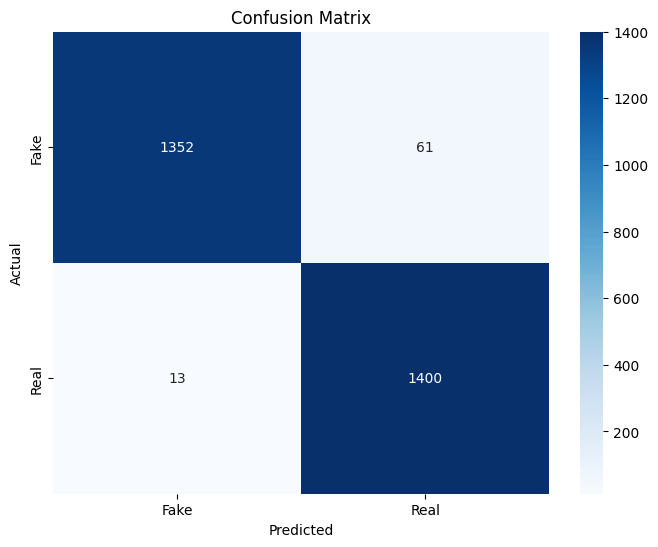

In [33]:
fake_file_names = [file_name for file_name in os.listdir(FAKE_AUDIO_PATH) if file_name.endswith('.wav')]
real_file_names = [file_name for file_name in os.listdir(REAL_AUDIO_PATH) if file_name.endswith('.wav')]

# Actual labels
y_actual = [0] * len(fake_file_names) + [1] * len(real_file_names)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_actual, y_pred_classes)

# Print classification report
print(classification_report(y_actual, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

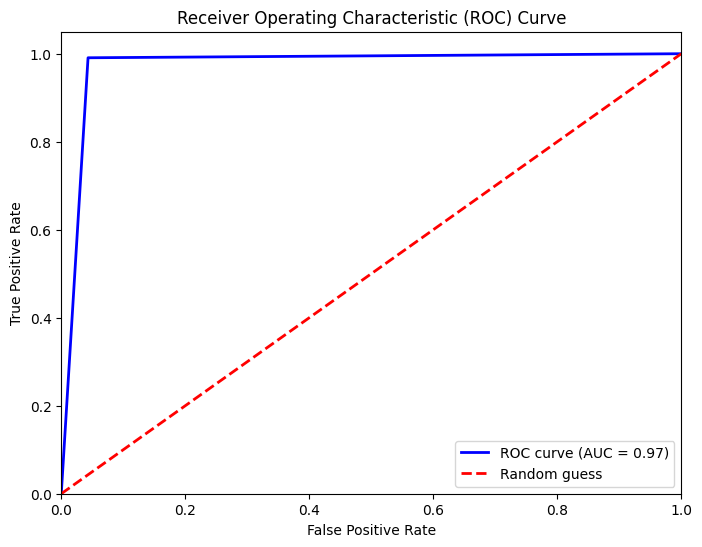

In [34]:
# Concatenate true labels for fake and real files
y_true = np.concatenate((np.zeros(len(fake_file_names)), np.ones(len(real_file_names))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_classes)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
fpr

array([0.        , 0.04317056, 1.        ])

In [36]:
tpr

array([0.        , 0.99079972, 1.        ])